## Plot time series of SEA-POL low-level rain rate
From Level4v1.1 PICCOLO_level4_rainrate_2D.nc

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap,Normalize
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D
#import cmweather
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Define color-blind safe colors
cb_orange = [230/255, 159/255, 0]
cb_skyblue = [86/255, 180/255, 233/255]
cb_green = [0, 158/255, 115/255]
cb_yellow = [240/255, 228/255, 66/255]
cb_blue = [0, 114/255, 178/255]
cb_red = [213/255, 94/255, 0]
cb_purple = [204/255, 121/255, 167/255]


In [3]:
# helper function for skinny box plots
def _q_stats(data):
    vals = np.array([v for v in data if not np.isnan(v)])
    if vals.size == 0:
        return np.nan, np.nan, np.nan, np.nan
    q1, q2, q3 = np.nanpercentile(vals, [25, 50, 75])
    mean = np.nanmean(vals)
    return q1, q2, q3, mean

In [18]:
# code for weighted mean hourly block average, adapted from code by Sarah Kennison
standard_time_grid = pd.date_range(np.datetime64('2024-08-16T08:00:00'), np.datetime64('2024-09-23T16:50:00'), freq='1 min')

def weighted_hourly_mean(values, sample_time, minute_index=standard_time_grid):
    """
    Compute time-weighted hourly block means for irregularly spaced samples by
    mapping each sample to the minute-resolution grid and then taking
    the per-hour average (weights = number of minutes).
    
    Adapted from function written by Sarah Kennison
    
    Parameters:
    - values: 1D array of sample values (example: list of P or I)
    - sample_time: datetime64 timestamps corresponding to sample values
    - minute_index: numpy.datetime64[minute] array of minute timestamps (standard_time_grid)
    Returns
    - values indexed by hourly timestamps with the time-weighted hourly means (NaN when no data)
    """
    
    # Reindex values from sample_time to minute_index, filling with NaNs where no data
    minute_index = pd.to_datetime(minute_index)
    vals_minute = values.reindex(time=minute_index)
    
    # Resample to hourly using the minute counts as weights (mean over minutes = time-weighted)
    hourly = vals_minute.resample(time='1h', label='left', closed='left').mean()
    return hourly

### Read in SEA-POL data

In [21]:
seapol = xr.open_dataset('../../data/SEA-POL_4v1.1_rainrate_2D_spatial_means.nc')
seapol

<xarray.Dataset> Size: 718kB
Dimensions:       (time: 8158)
Coordinates:
  * time          (time) datetime64[ns] 65kB 2024-08-16T08:10:00 ... 2024-09-...
Data variables: (12/15)
    rain245_mean  (time) float32 33kB ...
    rain120_mean  (time) float32 33kB ...
    rain60_mean   (time) float32 33kB ...
    rain12_mean   (time) float32 33kB ...
    rain1_mean    (time) float32 33kB ...
    rain245_int   (time) float32 33kB ...
    ...            ...
    rain1_int     (time) float32 33kB ...
    rain245_frac  (time) float64 65kB ...
    rain120_frac  (time) float64 65kB ...
    rain60_frac   (time) float64 65kB ...
    rain12_frac   (time) float64 65kB ...
    rain1_frac    (time) float64 65kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4v1.1 Gridded 2D Rain Rate
    units:        mm/h

### Read in IMERG and ERA_5 along track data. 

IMERG has been interpolated to a 0.25 degree grid and coarsened to hourly resolution. 

In [7]:
alongtrack = xr.open_dataset('../../data/IWVprecip_alongtrack.nc')
#precip_alongtrack_imerg
#precip_alongtrack_era5

### Coarsen SEA-POL to hourly block averages

In [24]:
rain245_hrly = weighted_hourly_mean(seapol.rain245_mean, seapol.time)
rain120_hrly = weighted_hourly_mean(seapol.rain120_mean, seapol.time)
rain60_hrly = weighted_hourly_mean(seapol.rain60_mean, seapol.time)
rain12_hrly = weighted_hourly_mean(seapol.rain12_mean, seapol.time)

rain245int_hrly = weighted_hourly_mean(seapol.rain245_int, seapol.time)
rain120int_hrly = weighted_hourly_mean(seapol.rain120_int, seapol.time)
rain60int_hrly = weighted_hourly_mean(seapol.rain60_int, seapol.time)
rain12int_hrly = weighted_hourly_mean(seapol.rain12_int, seapol.time)

rain245frac_hrly = weighted_hourly_mean(seapol.rain245_frac, seapol.time)
rain120frac_hrly = weighted_hourly_mean(seapol.rain120_frac, seapol.time)
rain60frac_hrly = weighted_hourly_mean(seapol.rain60_frac, seapol.time)
rain12frac_hrly = weighted_hourly_mean(seapol.rain12_frac, seapol.time)

### Plot multi-panel plot with hourly block average P, I, fa across different scales, plus panel with comparison to IMERG & ERA_5

/var/folders/j4/wzfdxl397kl09v45hngwvxd80000gp/T/ipykernel_36052/1252775632.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/var/folders/j4/wzfdxl397kl09v45hngwvxd80000gp/T/ipykernel_36052/1252775632.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/var/folders/j4/wzfdxl397kl09v45hngwvxd80000gp/T/ipykernel_36052/1252775632.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
/var/folders/j4/wzfdxl397kl09v45hngwvxd80000gp/T/ipykernel_36052/1252775632.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

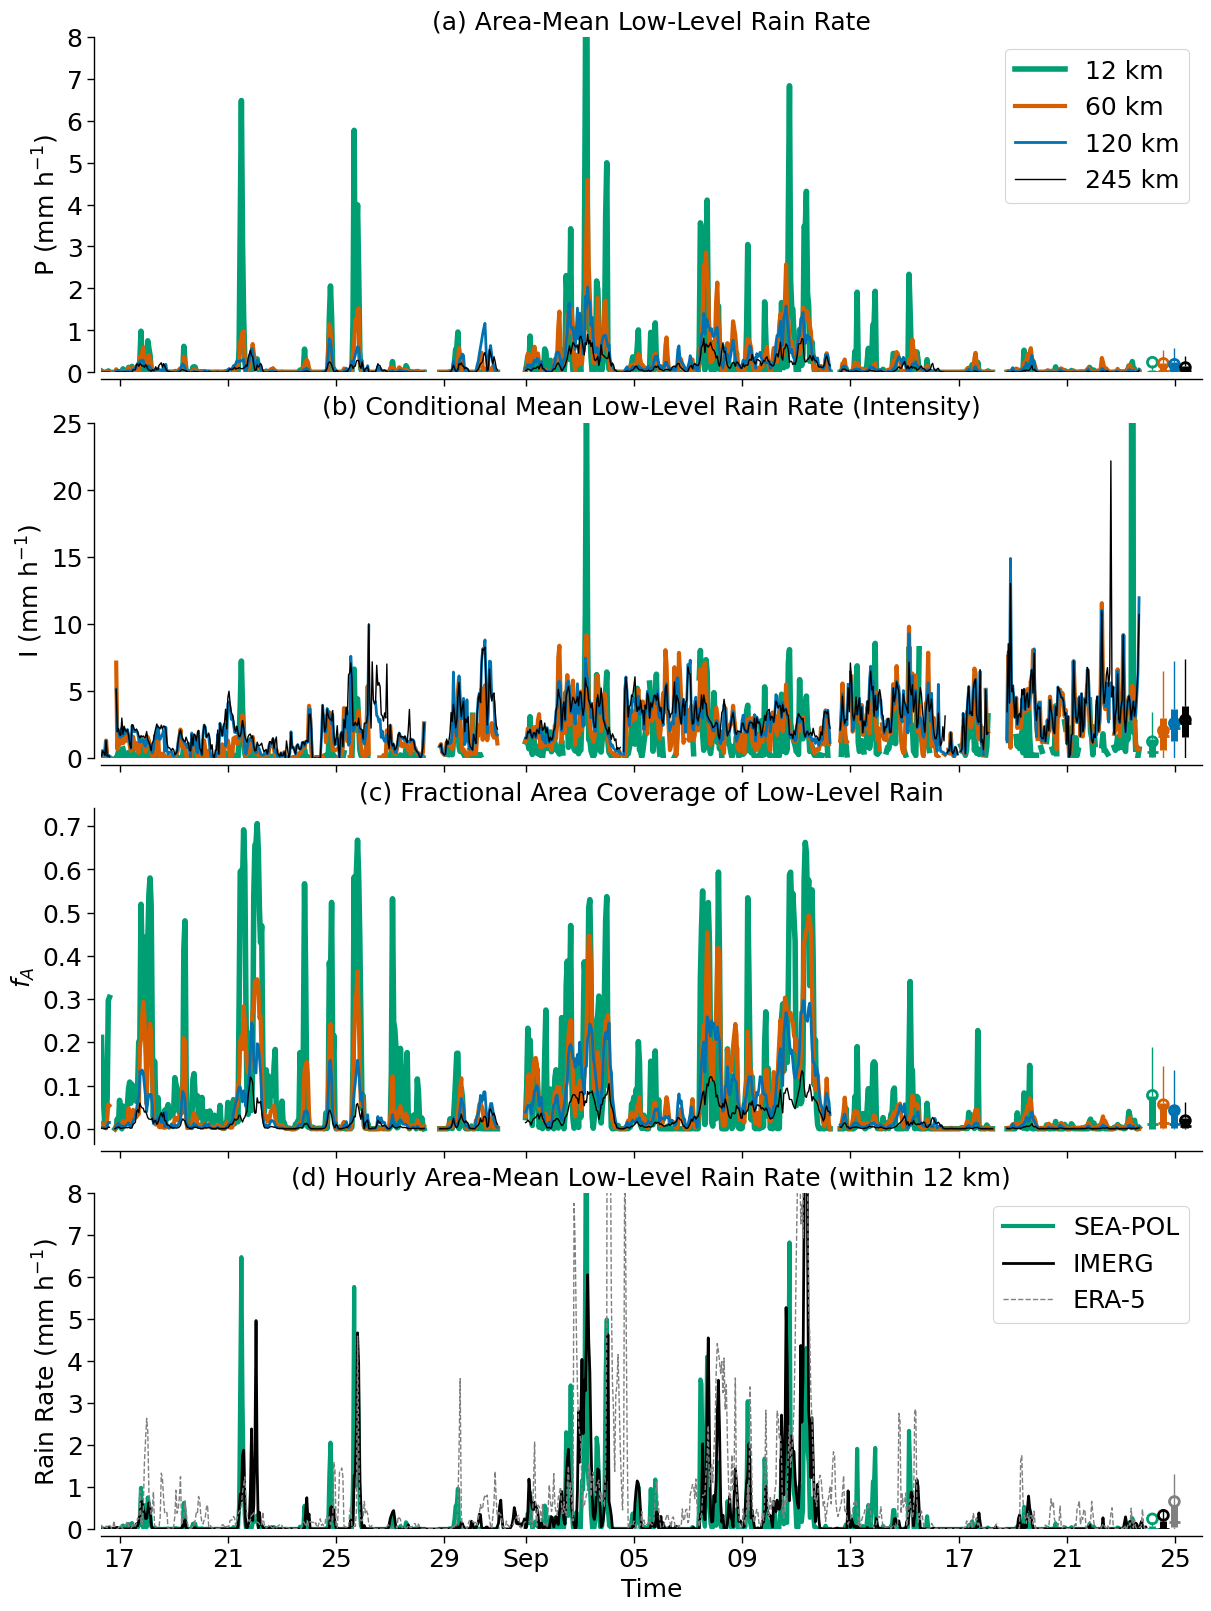

In [77]:
fig,axs = plt.subplots(4,1,figsize=(12,16),layout="constrained")

axs[0].plot(rain12_hrly.time, rain12_hrly, color=cb_green, label='12 km', linewidth=4)
axs[0].plot(rain60_hrly.time, rain60_hrly, color=cb_red, label='60 km', linewidth=3)
axs[0].plot(rain120_hrly.time, rain120_hrly, color=cb_blue, label='120 km', linewidth=2)
axs[0].plot(rain245_hrly.time, rain245_hrly, color='black', label='245 km', linewidth=1)
axs[0].set_title('(a) Area-Mean Low-Level Rain Rate',fontsize=18)
axs[0].set_ylabel('P (mm h$^{-1}$)', fontsize=18)
#axs[0].set_xlabel('Time',fontsize=18)

sns.set_context('paper') 
sns.despine(offset=5)

axs[0].set_ylim(0,8)
#axs[0].set_yscale('log')
axs[0].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-25 23:30'))

axs[0].legend(loc='upper right', fontsize=18)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

axs[0].set_xticklabels([])
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)

axs[1].plot(rain12int_hrly.time, rain12int_hrly, color=cb_green, label='12 km', linewidth=4)
axs[1].plot(rain60int_hrly.time, rain60int_hrly, color=cb_red, label='60 km', linewidth=3)
axs[1].plot(rain120int_hrly.time, rain120int_hrly, color=cb_blue, label='120 km', linewidth=2)
axs[1].plot(rain245int_hrly.time, rain245int_hrly, color='black', label='245 km', linewidth=1)
axs[1].set_title('(b) Conditional Mean Low-Level Rain Rate (Intensity)',fontsize=18)
axs[1].set_ylabel('I (mm h$^{-1}$)', fontsize=18)
#axs[1].set_xlabel('Time',fontsize=18)

axs[1].set_ylim(0,25)
#axs[1].set_yscale('log')
axs[1].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-25 23:30'))

#axs[1].legend(loc='upper left', fontsize=18)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

axs[1].set_xticklabels([])
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)

axs[2].plot(rain12frac_hrly.time, rain12frac_hrly, color=cb_green, label='12 km', linewidth=4)
axs[2].plot(rain60frac_hrly.time, rain60frac_hrly, color=cb_red, label='60 km', linewidth=3)
axs[2].plot(rain120frac_hrly.time, rain120frac_hrly, color=cb_blue, label='120 km', linewidth=2)
axs[2].plot(rain245frac_hrly.time, rain245frac_hrly, color='black', label='245 km', linewidth=1)
axs[2].set_title('(c) Fractional Area Coverage of Low-Level Rain',fontsize=18)
axs[2].set_ylabel('$f_A$', fontsize=18)
#axs[2].set_xlabel('Time',fontsize=18)

axs[2].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-25 23:30'))

#axs[2].legend(loc='upper right', fontsize=18)
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=18)
axs[2].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[2].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[2].xaxis.get_major_locator()))

axs[2].set_xticklabels([])
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=18)

axs[3].plot(rain12_hrly.time, rain12_hrly, color=cb_green, label='SEA-POL', linewidth=3)
axs[3].plot(alongtrack.time, alongtrack.precip_alongtrack_imerg, color='black', label='IMERG', linewidth=2)
axs[3].plot(alongtrack.time, alongtrack.precip_alongtrack_era5, color='gray', label='ERA-5', linewidth=1, linestyle = '--')

axs[3].set_title('(d) Hourly Area-Mean Low-Level Rain Rate (within 12 km)',fontsize=18)
axs[3].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
axs[3].set_xlabel('Time',fontsize=18)

axs[3].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-25 23:30'))
axs[3].set_ylim(0,8)
#axs[3].set_yscale('log')

axs[3].legend(loc='upper right', fontsize=18)
axs[3].set_yticklabels(axs[3].get_yticklabels(), fontsize=18)
axs[3].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[3].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[3].xaxis.get_major_locator()))

axs[3].set_xticklabels(axs[3].get_xticklabels(), fontsize=18)
axs[3].set_yticklabels(axs[3].get_yticklabels(), fontsize=18)

ax_P = axs[0]
ax_I = axs[1]
ax_fa = axs[2]
ax_comp = axs[3]

## plot whiskers/boxplots on each panel

plot_items = [(ax_P, rain12_hrly, cb_green),
              (ax_I, rain12int_hrly, cb_green),
              (ax_fa, rain12frac_hrly, cb_green),
              (ax_comp, rain12_hrly, cb_green)]

for ax, data_list, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.955 #move a bit closer to the right edge
    dx_frac = 0.005 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=dot_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=dot_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               edgecolor=dot_color, facecolor='none', s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=dot_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=dot_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)

# plot next set of box plots
plot_items = [(ax_P, rain60_hrly, cb_red),
              (ax_I, rain60int_hrly, cb_red),
              (ax_fa, rain60frac_hrly, cb_red),
              (ax_comp, alongtrack.precip_alongtrack_imerg, 'black')]

for ax, data_list, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.965 #move a bit closer to the right edge
    dx_frac = 0.005 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=dot_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=dot_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               edgecolor=dot_color, facecolor='none', s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=dot_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=dot_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)

# plot next set of box plots
plot_items = [(ax_P, rain120_hrly, cb_blue),
              (ax_I, rain120int_hrly, cb_blue),
              (ax_fa, rain120frac_hrly, cb_blue),
              (ax_comp, alongtrack.precip_alongtrack_era5, 'gray')]

for ax, data_list, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.975 #move a bit closer to the right edge
    dx_frac = 0.005 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=dot_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=dot_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               edgecolor=dot_color, facecolor='none', s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=dot_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=dot_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)
    
    # plot next set of box plots
plot_items = [(ax_P, rain245_hrly, 'black'),
              (ax_I, rain245int_hrly, 'black'),
              (ax_fa, rain245frac_hrly, 'black')]

for ax, data_list, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.985 #move a bit closer to the right edge
    dx_frac = 0.005 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=dot_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=dot_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               edgecolor=dot_color, facecolor='none', s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=dot_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=dot_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line) 
 
plt.savefig('../../figures/Fig_precip_timeseries_hrly.png')

In [33]:
#Find where mean rain rate greater than upper limit of plot
int_limit = 8
rain12mean_gt = np.where(rain12_hrly > int_limit)[0]
print('rain12mean >',int_limit,':',rain12_hrly[rain12mean_gt].values)
print('rain12mean >',int_limit,'times:',rain12_hrly.time[rain12mean_gt].values)

rain12mean > 8 : [13.706211]
rain12mean > 8 times: ['2024-09-03T06:00:00.000000000']


In [31]:
#Find where intensity greater than upper limit of plot
int_limit = 25
rain12int_gt = np.where(rain12int_hrly > int_limit)[0]
print('rain12int >',int_limit,':',rain12int_hrly[rain12int_gt].values)
print('rain12int >',int_limit,'times:',rain12int_hrly.time[rain12int_gt].values)



rain12int > 25 : [27.136175 65.856834]
rain12int > 25 times: ['2024-09-03T06:00:00.000000000' '2024-09-23T10:00:00.000000000']


In [35]:
#Find where mean rain rate with imerg & era5 greater than upper limit of plot
int_limit = 8
imerg_gt = np.where(alongtrack.precip_alongtrack_imerg > int_limit)[0]
era5_gt = np.where(alongtrack.precip_alongtrack_era5 > int_limit)[0]
print('imerg >',int_limit,':',alongtrack.precip_alongtrack_imerg[imerg_gt].values)
print('imerg >',int_limit,'times:',alongtrack.time[imerg_gt].values)
print('era5 >',int_limit,':',alongtrack.precip_alongtrack_era5[era5_gt].values)
print('era5 >',int_limit,'times:',alongtrack.time[era5_gt].values)

imerg > 8 : [14.42374945 16.63374949]
imerg > 8 times: ['2024-09-11T08:00:00.000000000' '2024-09-11T09:00:00.000000000']
era5 > 8 : [25.54922104 12.88704872 10.63871384  9.75294113  8.09941292  8.41655731
  9.44395065 15.10362625 12.83426285  9.67998505  8.34789276]
era5 > 8 times: ['2024-09-04T01:00:00.000000000' '2024-09-04T02:00:00.000000000'
 '2024-09-04T03:00:00.000000000' '2024-09-04T16:00:00.000000000'
 '2024-09-11T01:00:00.000000000' '2024-09-11T02:00:00.000000000'
 '2024-09-11T03:00:00.000000000' '2024-09-11T07:00:00.000000000'
 '2024-09-11T08:00:00.000000000' '2024-09-11T09:00:00.000000000'
 '2024-09-11T10:00:00.000000000']


In [ ]:
# Old code for block average, starting from regularly spaced data
# ncoarsen = 6 # 6 10-minute intervals for 1 hour, 12 5-minute intervals for 1 hour

#rain245_hrly = seapol.rain245_mean.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
#rain120_hrly = seapol.rain120_mean.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
#rain60_hrly = seapol.rain60_mean.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
#rain12_hrly = seapol.rain12_mean.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
#rain1_hrly = seapol.rain1_mean.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')

#rain245int_hrly = seapol.rain245_int.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
#rain120int_hrly = seapol.rain120_int.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
#rain60int_hrly = seapol.rain60_int.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
#rain12int_hrly = seapol.rain12_int.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
#rain1int_hrly = seapol.rain1_int.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')

#rain245frac_hrly = seapol.rain245_frac.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
#rain120frac_hrly = seapol.rain120_frac.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
#rain60frac_hrly = seapol.rain60_frac.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
#rain12frac_hrly = seapol.rain12_frac.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
#rain1frac_hrly = seapol.rain1_frac.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')

Plot

In [37]:
#find where alongtrack.time is rain12_hrly.time[-1]
rain12_hrly_time = pd.to_datetime(rain12_hrly.time.values)
last_time = rain12_hrly_time[-1]
alongtrack_time = pd.to_datetime(alongtrack.time.values)
last_alongtrack_idx = np.where(alongtrack_time == last_time)[0][0]

/var/folders/j4/wzfdxl397kl09v45hngwvxd80000gp/T/ipykernel_36052/2958307421.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/var/folders/j4/wzfdxl397kl09v45hngwvxd80000gp/T/ipykernel_36052/2958307421.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/var/folders/j4/wzfdxl397kl09v45hngwvxd80000gp/T/ipykernel_36052/2958307421.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


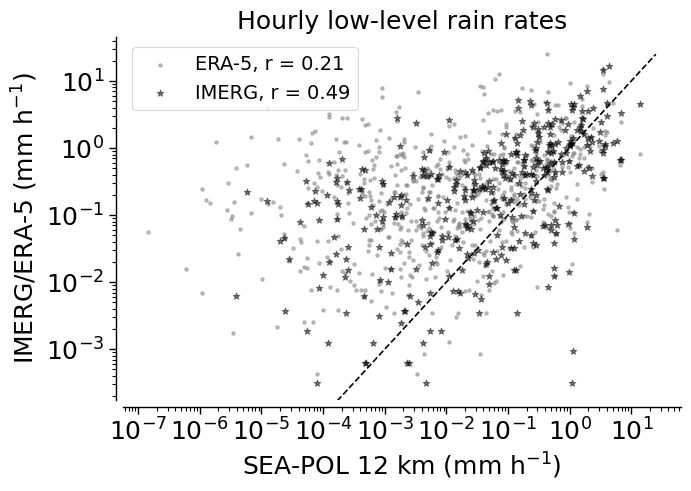

In [78]:
# Scatter plot of imerg and era-5 against rain12_hrly
fig, ax = plt.subplots(figsize=(7, 5), layout="constrained")

#plot 1:1 line
x = np.linspace(0, 25, 100)
ax.plot(x, x, color='black', linestyle='--')

#calculate correlation coefficient, ignoring nans
corr_imerg = np.corrcoef(rain12_hrly[~np.isnan(rain12_hrly)], alongtrack.precip_alongtrack_imerg[0:last_alongtrack_idx+1][~np.isnan(rain12_hrly)])[0, 1]
corr_era5 = np.corrcoef(rain12_hrly[~np.isnan(rain12_hrly)], alongtrack.precip_alongtrack_era5[0:last_alongtrack_idx+1][~np.isnan(rain12_hrly)])[0, 1]
#ax.text(0.05, 0.95, f'IMERG r = {corr_imerg:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
#ax.text(0.05, 0.90, f'ERA-5 r = {corr_era5:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')

ax.scatter(rain12_hrly,alongtrack.precip_alongtrack_era5[0:last_alongtrack_idx+1], color='gray', marker='.',label=f'ERA-5, r = {corr_era5:.2f}', alpha=0.5)
ax.scatter(rain12_hrly,alongtrack.precip_alongtrack_imerg[0:last_alongtrack_idx+1], color='black', marker='*', label=f'IMERG, r = {corr_imerg:.2f}', alpha=0.5)

#log scale 
ax.set_xscale('log')
ax.set_yscale('log')

sns.set_context('paper') 
sns.despine(offset=5)

ax.set_ylabel('IMERG/ERA-5 (mm h$^{-1}$)', fontsize=18)
ax.set_xlabel('SEA-POL 12 km (mm h$^{-1}$)', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_title('Hourly low-level rain rates', fontsize=18)
ax.legend(loc='upper left', fontsize=14)

plt.tight_layout()
plt.savefig('../../figures/Fig_SEAPOL_IMERG_ERA5_scatter.png') 

SEA-POL hourly running mean

In [47]:
#Read in data on regular 10-minute grid 
seapol_reg = xr.open_dataset('../../data/SEA-POL_4v1.1_rainrate_2D_spatial_means_reg10.nc')

In [48]:
# SEA-POL hourly running mean
rain12_hrly_run = seapol_reg.rain12_mean.rolling(time=6, center=True).mean() # 6*10=60 minute running mean

/var/folders/j4/wzfdxl397kl09v45hngwvxd80000gp/T/ipykernel_36052/422553208.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


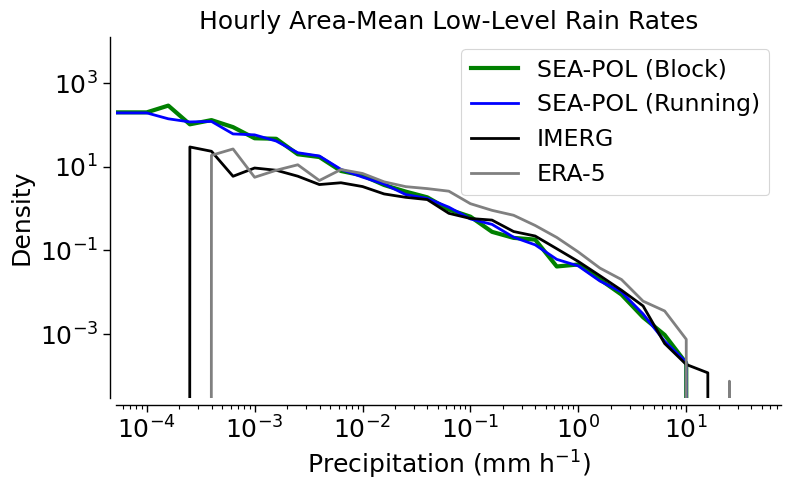

In [49]:
fig,ax = plt.subplots(figsize=(8,5),layout="constrained")

pbins = np.concatenate(([0],np.power(10,np.arange(-4,2,0.2))))

## SEA-POL 12 km
phist_seapol12, bin_edges = np.histogram(rain12_hrly, bins=pbins, density=True)
phist_seapol12_run, bin_edges = np.histogram(rain12_hrly_run, bins=pbins, density=True)
phist_imerg, bin_edges = np.histogram(alongtrack.precip_alongtrack_imerg[0:last_alongtrack_idx+1], bins=pbins, density=True)
phist_era5, bin_edges = np.histogram(alongtrack.precip_alongtrack_era5[0:last_alongtrack_idx+1], bins=pbins, density=True)

ax.plot(bin_edges[:-1], phist_seapol12, color='green', label='SEA-POL (Block)', linewidth=3)
ax.plot(bin_edges[:-1], phist_seapol12_run, color='blue', label='SEA-POL (Running)', linewidth=2)
ax.plot(bin_edges[:-1], phist_imerg, color='black', label='IMERG',linewidth=2)
ax.plot(bin_edges[:-1], phist_era5, color='gray', label='ERA-5',linewidth=2)

ax.set_title('Hourly Area-Mean Low-Level Rain Rates',fontsize=18)
ax.set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
ax.set_ylabel('Density',fontsize=18)
#ax.set_xlim(0,25)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=17, loc='upper right')
ax.tick_params(labelsize=18)

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout() 

plt.savefig('../../figures/Fig_SEAPOL_IMERG_ERA5_pdf.png')